In [1]:
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from collections import namedtuple
import heapq
import seaborn as sns

from market import SimulationClock
from market import Exchange

In [2]:
def bgt_scheduler( clock, FV, p_flex, lam, order_size_bound, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    quantity = np.random.randint(1,order_size_bound+1)*np.random.choice([-1,1])
    price = FV + np.random.randint(-p_flex,p_flex+1)
    heapq.heappush(event_queue,[clock.time+delta_t, price,quantity,trader,order_type])

def agressor_scheduler(a1, a2, a3, b1, b2, b3, c1, c2, c3, d1, d2, d3, clock, lam, ba, bb, lastprice, depth, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    if lastprice >= ba:
        quantity = a1*(lastprice - ba) + b1*depth
        price = c1*lastprice + d1*depth
    elif lastprice < bb:
        quantity = a2*(lastprice - bb) - b2*depth
        price = c2*lastprice + d2*depth
    else:
        quantity = 0
        price = c3*lastprice + d3*depth
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass

def mm1_scheduler(clock, e1, f1, ba, bb, trader):
    order_type = 0
    lam = e1
    delta_t = np.random.exponential(lam)
    buy_sell_sign = np.random.choice([-1,1])
    if buy_sell_sign > 0:
        price = bb
        quantity = buy_sell_sign*f1
    else:
        price = ba
        quantity = buy_sell_sign*f1
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass

def mm2_scheduler(clock, g1, h1, i1, j1, lam, mm2_q, ba, bb, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    buy_sell_sign = np.random.choice([-1,1])
    if buy_sell_sign > 0:
        price = min(bb+g1,ba-h1)
        quantity = buy_sell_sign*mm2_q
    else:
        price = max(bb+i1,ba-j1)
        quantity = buy_sell_sign*mm2_q
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass

def mm3_scheduler(clock, g1, h1, i1, j1, k1, l1, ba, bb, trader):
    order_type = 0
    delta_t = np.random.exponential(k1)
    buy_sell_sign = np.random.choice([-1,1])
    if buy_sell_sign > 0:
        price = min(bb+g1,max(ba-h1,bb))
        quantity = buy_sell_sign*l1
    else:
        price = max(min(bb+i1,ba),ba-j1)
        quantity = buy_sell_sign*l1
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass


In [3]:
generations = 20
population_size = 50
selection = 10
n_params = 2
mutation_rate = 0.5
mutation_decay = 0.90
num_of_smart_robot = 1

sim_duration = 50
burn_in = 5
n_bgts = 100

# parameters 
e1 = np.random.uniform(0.4,1,population_size)
f1 = np.random.uniform(0,20,population_size)
g1 = np.random.uniform(0,5,population_size)
h1 = np.random.uniform(0,5,population_size)
i1 = np.random.uniform(0,5,population_size)
j1 = np.random.uniform(0,5,population_size)
k1 = np.random.uniform(0.4,1,population_size)
l1 = np.random.uniform(0,20,population_size)

def mutate1(idx):
    if idx == 0:
        return np.random.uniform(0.4,1)
    elif idx == 1:
        return np.random.uniform(0,20)

    
def mutate2(idx):
    if idx == 0:
        return np.random.uniform(0,5)
    elif idx == 1:
        return np.random.uniform(0,5)
    elif idx == 2:
        return np.random.uniform(0,5)
    elif idx == 3:
        return np.random.uniform(0,5)

population1 = list(zip(e1,f1))
population2 = list(zip(g1,h1,i1,j1))

population1_record = []
population2_record = []

for gen in range(generations): 
    population1_record.append(population1)
    population2_record.append(population2)

# simulate
    events = []
    FVs = []
    clk = SimulationClock()
    exch = Exchange(clk)
    BAs = []
    BBs = []
    t=0

    order_size_bound = 100
    FV = 100
    p_flex = 3
    p_reset = 0.01
    lam_bgt = 0.5
    lam_mm = 0.5

    event_queue = []

    #init
    for trader in range(0,n_bgts):
        bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)

    #burn_in
    while clk.time < burn_in:
        # execute next event
        event = heapq.heappop(event_queue)
        event_time, price, quantity, trader, order_type = event
        clk.time = event_time
        exch.post(price, quantity, trader, order_type)
        # reset FV
        if trader < n_bgts:
            if np.random.rand(1) < p_reset:
                FV = price
        # schedule new event
        bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)

        # stats
        events.append([clk.time,event[2],event[1]]) 
        FVs.append(FV)
        ba = exch.get_best_ask()
        bb = exch.get_best_bid()
        if ba == None:
            ba_price = FV
        else:
            ba_price = ba.price
        if bb == None:
            bb_price = FV
        else:
            bb_price = -bb.price
        BAs.append(ba_price)
        BBs.append(bb_price)

    depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]
    
    for trader in range(n_bgts,n_bgts+population_size):
        k = trader - n_bgts
        params = population1[k]
        mm1_scheduler(clk, params[0], params[1], BAs[-1], BBs[-1], trader)

    
    for trader in range(n_bgts+population_size,n_bgts+2*population_size):
        k = trader - n_bgts - population_size
        params = population2[k]
        mm3_scheduler(clk, params[0], params[1], params[2], params[3], lam_mm, 20, BAs[-1], BBs[-1], trader)

    while clk.time < sim_duration:
        # execute next event
        event = heapq.heappop(event_queue)
        event_time, price, quantity, trader, order_type = event
        clk.time = event_time
        exch.post(price, quantity, trader, order_type)
        # reset FV
        if trader < n_bgts:
            if np.random.rand(1) < p_reset:
                FV = price

        # stats
        events.append([clk.time,event[2],event[1]]) 
        FVs.append(FV)
        ba = exch.get_best_ask()
        bb = exch.get_best_bid()
        if ba == None:
            ba_price = FV
        else:
            ba_price = ba.price
        if bb == None:
            bb_price = FV
        else:
            bb_price = -bb.price
        BAs.append(ba_price)
        BBs.append(bb_price)

        depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]

        # schedule new event
        if trader >= n_bgts + population_size:
            k = trader - n_bgts - population_size
            params = population2[k]
            mm3_scheduler(clk, params[0], params[1], params[2], params[3], lam_mm, 20, BAs[-1], BBs[-1], trader)        
        elif trader >= n_bgts:
            k = trader - n_bgts
            params = population1[k]
            mm1_scheduler(clk, params[0], params[1], BAs[-1], BBs[-1], trader)
        else:    
            bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)
    
    # profit calculation
    trades = np.array(exch.trades)
    profit1=[]
    for i in range(n_bgts,n_bgts+population_size):
        profit1.append(-sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6]*trades[trades[:,4]==i][:,2]) 
                      +sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]*trades[trades[:,5]==i][:,2])
                      +(sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6])
                      -sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]))*exch.lastprice)
    profit2=[]
    for i in range(n_bgts+population_size,n_bgts + 2*population_size):
        profit2.append(-sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6]*trades[trades[:,4]==i][:,2]) 
                      +sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]*trades[trades[:,5]==i][:,2])
                      +(sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6])
                      -sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]))*exch.lastprice)
# evolution
    profit1 = np.array(profit1)
    population1 = np.array(population1)
    top_traders1 = profit1.argsort()[-selection:][::-1]
    #print(top_traders)
    top_profit1 = profit1[top_traders1]
    top_params1 = population1[top_traders1]
    
    profit2 = np.array(profit2)
    population2 = np.array(population2)
    top_traders2 = profit2.argsort()[-selection:][::-1]
    #print(top_traders)
    top_profit2 = profit2[top_traders2]
    top_params2 = population2[top_traders2]
    
    print('gen',gen)
    print('mutation_rate',mutation_rate)
    print('top profit1\n',top_profit1)
    print('top parameters1\n',top_params1)
    print('top profit2\n',top_profit2)
    print('top parameters2\n',top_params2)
    
    new_params1 = []
    for i in range(top_params1.shape[1]):
        new_params1.append(np.random.choice(top_params1[:,i],population_size))
    
    new_params2 = []
    for i in range(top_params2.shape[1]):
        new_params2.append(np.random.choice(top_params2[:,i],population_size))
    
    population1 = np.column_stack(new_params1)
    for i in range(population_size):
        for j in range(len(population1[i])):
            if np.random.rand(1) < mutation_rate:
                population1[i][j] = mutate1(j)
    
    population2 = np.column_stack(new_params2)
    for i in range(population_size):
        for j in range(len(population2[i])):
            if np.random.rand(1) < mutation_rate:
                population2[i][j] = mutate2(j)
    #population = population[:population_size]
    #population
    
    mutation_rate = mutation_rate * mutation_decay
    
    


gen 0
mutation_rate 0.5
top profit1
 [489.52539422 262.30994937 219.25682515 136.3896801   79.30472564
  78.65069775  72.75695535  59.35015943  50.45105793  19.92541538]
top parameters1
 [[ 0.53491724  5.37326254]
 [ 0.75057767  6.70323482]
 [ 0.88851899  4.38256675]
 [ 0.43779854  2.70107706]
 [ 0.45642953 19.27667401]
 [ 0.67807969 16.9831598 ]
 [ 0.55806001  1.61462253]
 [ 0.72222787  6.20627315]
 [ 0.83585826  0.72502127]
 [ 0.58080936 16.52113786]]
top profit2
 [2014.30590122 1745.67850483 1420.41055585 1309.20466275 1025.66226806
  923.78645696  497.80073512  427.6266327    69.08584389  -27.12497639]
top parameters2
 [[3.41099497 0.5600136  0.01135975 3.8660512 ]
 [2.25985917 3.81710403 3.4977749  4.05907155]
 [2.25269012 4.69277728 2.73464039 2.32884484]
 [0.56198271 2.92989789 1.42630782 0.22426933]
 [2.10923916 0.38858252 1.92785193 1.24225675]
 [3.75818267 4.60059654 2.69268242 2.94254154]
 [2.90053121 0.50388925 4.05109185 3.60006371]
 [0.50172393 1.79616711 2.64280929 2.133

gen 8
mutation_rate 0.21523360500000008
top profit1
 [ 716.6878101   467.17119596  299.71907274  245.74174342  230.3059402
   51.13685979  -33.00382327 -173.91850859 -175.96322893 -310.63246675]
top parameters1
 [[ 0.59796542 12.40622793]
 [ 0.80690585 11.7280309 ]
 [ 0.67567882 18.60892178]
 [ 0.89482894 14.33567523]
 [ 0.68606673 14.33567523]
 [ 0.72604515 12.38912574]
 [ 0.68606673 11.7280309 ]
 [ 0.80690585  2.13214527]
 [ 0.74621711 12.38912574]
 [ 0.78771649  7.50629638]]
top profit2
 [3831.10530507 1483.46004676 1412.72048644  715.8337291   481.39143577
  349.74585234   35.57519668  -34.8820796  -229.64981753 -733.57687136]
top parameters2
 [[2.26296576 3.76311935 0.2095458  2.79358781]
 [1.20530967 2.9331788  4.9082751  4.44117331]
 [3.2822194  2.92989789 0.2095458  4.84657113]
 [3.2822194  1.97874701 2.54611913 1.81081794]
 [4.4108645  1.97874701 0.2095458  2.32912443]
 [4.12374194 3.28479893 2.83583205 1.05972313]
 [3.26350401 3.28479893 0.62340404 3.1595052 ]
 [0.43182803 4.

gen 16
mutation_rate 0.0926510094425921
top profit1
 [740.02336278 701.00371986 462.724261   460.53363423 455.43638723
 395.30591815 371.38491543 292.01758748 265.01491709 254.72792406]
top parameters1
 [[ 0.63736091 14.72200169]
 [ 0.82010271 11.61662838]
 [ 0.82010271 15.55817097]
 [ 0.56407394 17.81475287]
 [ 0.68852012 15.55817097]
 [ 0.56407394 18.37237811]
 [ 0.82010271 15.55817097]
 [ 0.75416276 18.37237811]
 [ 0.68852012 15.55817097]
 [ 0.68852012 15.55817097]]
top profit2
 [2081.20193838 1730.10181111 1126.7021645  1064.72373374 1031.69727079
  997.26611767  947.19800561  908.13236507  671.69495811  601.22184099]
top parameters2
 [[2.47446007 2.1246479  3.32228178 4.32833204]
 [2.43609361 4.98070071 2.83583205 4.32833204]
 [3.70356623 2.1246479  3.32228178 4.32833204]
 [3.57638851 4.16154636 0.88175841 2.18865727]
 [1.20530967 2.1246479  0.62340404 4.11243769]
 [2.43609361 4.11792544 3.68879414 4.11243769]
 [2.19757867 2.1246479  0.84165471 4.11243769]
 [1.20530967 4.9253493  

In [8]:
import pandas as pd

In [15]:
e1_record = pd.DataFrame(np.array(population1_record)[:,:,0])

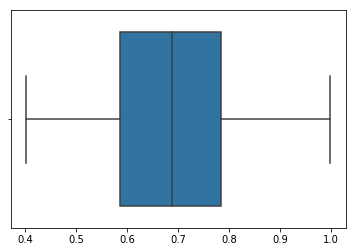

In [18]:
sns.boxplot(np.array(population1_record)[:,:,0])

In [4]:
trades = np.array(exch.trades)
#exch.trades

In [5]:
events = np.array(events)

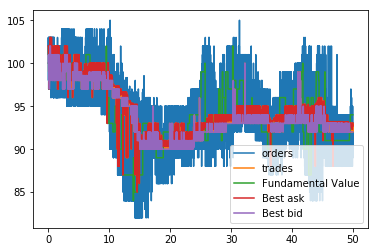

In [6]:
plt.plot(events[:,0],events[:,2], label = 'orders')
plt.plot(trades[:,0],trades[:,2], label = 'trades')
plt.plot(events[:,0],FVs, label = 'Fundamental Value')
plt.plot(events[:,0],BAs, label = 'Best ask')
plt.plot(events[:,0],BBs, label = 'Best bid')
plt.legend()

In [131]:
#list(zip(BAs,BBs))
#np.sort(np.array(exch.bids,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#np.sort(np.array(exch.asks,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#len(events)